In [1]:
import json
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
PATH_TO_HUMAN_COUNTS = "../data/codon_counts_GRCh37.json"
PATH_TO_SIGNATURES = "../data/external/COSMIC_v3.2_SBS_GRCh37.txt"
PATH_TO_SIGNATURES_NORMALIZED = "../data/COSMIC_v3.2_SBS_GRCh37_normalized.txt"
PATH_TO_MUTSPEC = "../data/ms96.tsv"

In [3]:
translator = str.maketrans("ATGC", "TACG")


In [4]:
def load_triplet_counts(path: str, normalize=False) -> pd.Series:
    """ read and collapse raw trinucleotide counts """
    considerable_nucs = {"C", "T"}
    with open(path) as fin:
        counts = json.load(fin)

    new_counts = defaultdict(int)
    for trinuc, num in counts.items():
        standart_trinuc = trinuc.upper()
        if len(set(standart_trinuc).difference("ATGC")) == 0:
            if standart_trinuc[1] not in considerable_nucs:
                standart_trinuc = standart_trinuc.translate(translator)
            new_counts[standart_trinuc] += num
            
    new_counts = pd.Series(new_counts)
    if normalize:
        new_counts = new_counts / new_counts.median()
    return new_counts.sort_index()

In [5]:
human_triplet_counts = load_triplet_counts(PATH_TO_HUMAN_COUNTS, True)
signatures = pd.read_csv(PATH_TO_SIGNATURES, sep="\t", index_col=0)
signatures_norm = pd.read_csv(PATH_TO_SIGNATURES_NORMALIZED, sep="\t", index_col=0)
mutspec = pd.read_csv(PATH_TO_MUTSPEC, sep="\t")

In [6]:
mutspec.head()

,Mutation Types,sars-cov-2_ff_m
0,A[C>A]A,88.209302
1,A[C>A]C,77.825000
2,A[C>A]G,84.454545
3,A[C>A]T,89.534884
4,A[C>G]A,3.860465


<AxesSubplot:>

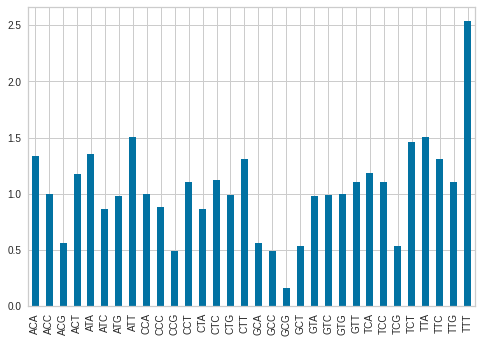

In [83]:
human_triplet_counts.plot.bar()

In [84]:
mutspec["Context"] = mutspec["Mutation Types"].str.extract(
    "(\w)\[(\w)>\w\](\w)").apply(lambda x: "".join(x), axis=1)

In [85]:
mutspec.head()

,Mutation Types,sars-cov-2_ff_m,Context
0,A[C>A]A,88.209302,ACA
1,A[C>A]C,77.825000,ACC
2,A[C>A]G,84.454545,ACG
3,A[C>A]T,89.534884,ACT
4,A[C>G]A,3.860465,ACA


In [99]:
triplet_freqs = human_triplet_counts.reset_index(name="Freq").rename({"index": "Context"}, axis=1)

In [109]:
ext_mutspec = pd.merge(mutspec, triplet_freqs, on="Context").sort_values("Mutation Types")
ext_mutspec.head()

,Mutation Types,sars-cov-2_ff_m,Context,Freq
0,A[C>A]A,88.209302,ACA,1.334506
3,A[C>A]C,77.825000,ACC,1.000506
6,A[C>A]G,84.454545,ACG,0.561735
9,A[C>A]T,89.534884,ACT,1.180098
1,A[C>G]A,3.860465,ACA,1.334506


In [110]:
additional_cols = {"Context", "Freq", "Mutation Types"}
for c in ext_mutspec.columns:
    if c in additional_cols:
        continue
    for lbl, func in [("floor", np.floor), ("ceil", np.ceil)]:
        ext_mutspec[f"{c}_{lbl}"] = func(ext_mutspec[c] * ext_mutspec["Freq"]).astype(int)
    ext_mutspec.drop(c, axis=1, inplace=True)
ext_mutspec.drop(["Context", "Freq"], axis=1, inplace=True)

In [111]:
ext_mutspec.to_csv("../data/ms96_norm_to_human.tsv", sep="\t", index=None)